# Currency Hedging
Assume that an EUR based investor is investing in EUR and US equities and EUR and
USD denominated zero coupon bonds. The investor has a one year investment horizon.
The investor’s objective is to find the optimal portfolio when allowing hedging of the USD
exposure. The hedging will be performed using one year FX forward contracts that allows
the investor to buy or sell one USD at a pre-specified price in one year.

The market is assumed to be driven by a set of market invariants:

\
\begin{align*}
\Delta X_t = \left(\begin{array}{c}
\Delta \log FX_t \\
\Delta \log V_t^{US,local} \\
\Delta \log V_t^{EUR} \\
\Delta y_t^{EUR,1/12} \\
\Delta y_t^{EUR,1} \\
\Delta y_t^{EUR,3} \\
\Delta y_t^{EUR,5} \\
\Delta y_t^{EUR,7} \\
\Delta y_t^{EUR,10} \\
\Delta y_t^{USD,1/12} \\
\Delta y_t^{USD,1} \\
\Delta y_t^{USD,3} \\
\Delta y_t^{USD,5} \\
\Delta y_t^{USD,7} \\
\Delta y_t^{USD,10}
\end{array}\right)
\end{align*}

The time step is assumed to be one week or 1/52 years. $FX_t$ denotes the EUR/USD exchange rate, the number of USD required to buy one EUR, $\log V_t^{US,local}$ denotes the value of US equities measured in USD, $\log V_t^{EUR}$ denotes the value of EUR equities measured in EUR, $y_t^{x,\tau}$ is the $\tau$ year continuously compounded zero coupon yield for the $x$ economy. The whole USD and EUR yield curve is spanned by these two set of zero coupon yields. The yields for any given time to maturity can be obtained by linear interpolation.

The market invariants are normally distributed

$$
\Delta X_t \sim \mathcal{N}(\mu, \Sigma)
$$

The covariance matrix is provided in the file `covariance_matrix.xlsx`. The vector of expectations is given by $\mu = (0, 0.07 \cdot \Delta t, 0.06 \cdot \Delta t, 0^T,0^T)^T$.

## Loading packages

In [14]:

from scipy.optimize import minimize
import scipy.optimize as optimize
import cvxpy as cp
from scipy import stats
from scipy.stats import wishart, norm, lognorm
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import pandas as pd
covariance_matrix=pd.read_excel(r"/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Data/covariance_matrix.xlsx", index_col=0)
#covariance_matrix=pd.read_excel(r"C:\Users\thorb\Documents\Github Repositories\PyExam\Data\covariance_matrix.xlsx", index_col=0)
init_values=pd.read_excel(r"/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Data/init_values.xlsx", index_col=0)
#init_values=pd.read_excel(r"C:\Users\thorb\Documents\Github Repositories\PyExam\Data\init_values.xlsx", index_col=0)

#Transform data
import numpy as np
cov_matrix = covariance_matrix.to_numpy()
x0 = init_values["initial values"].to_numpy()

#General parameters
delta_t = 1 / 52
mean_vector = np.array([0,0.07 * delta_t, 0.06 * delta_t] + [0] * (len(covariance_matrix) - 3))

pastel_colors = ["#F4D39E", "#F4B79A", "#E8A6C1", "#C7A6E3", "#9FCDEA"]

## Question 1
Assume that we are standing at time $t = 0$ with initial values, $x_0$, as specified in `init_values.xlsx`. What is the distribution of $X_1$? Simulate the evolution of $X_t$ with weekly time steps from time zero to the horizon. Visualize the evolution of $\log F{X_t}$.


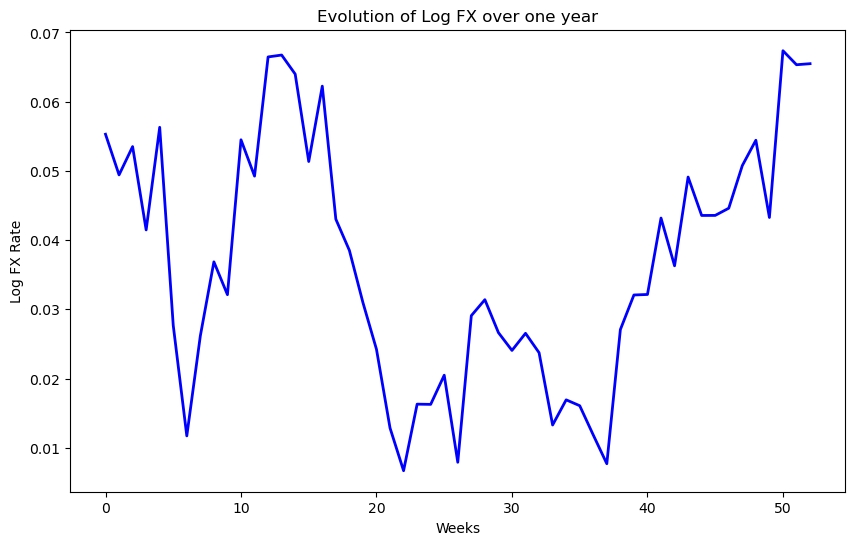

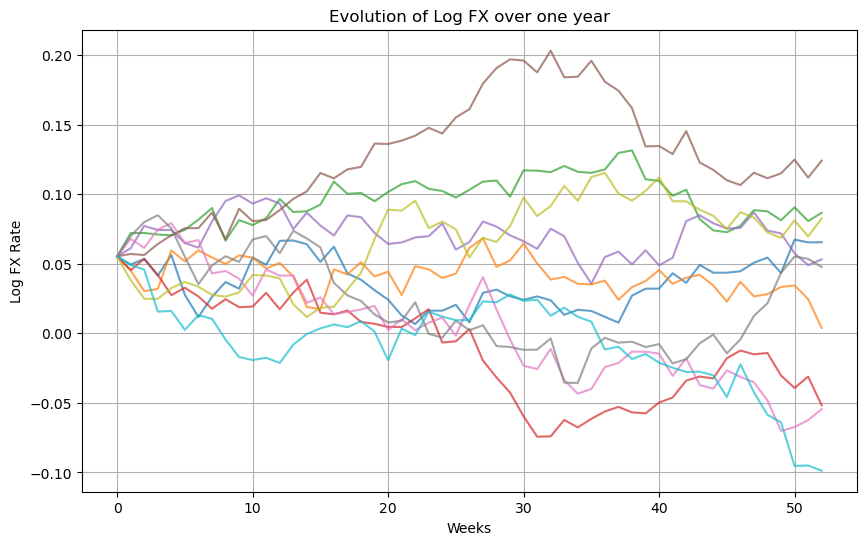

In [16]:
#Defining the parameters:
mu=mean_vector
time_horizon = 52
num_simulations = 100000

#Simulating X_t evolution:
np.random.seed(42)
X_t = np.zeros((time_horizon + 1, len(x0), num_simulations))
X_t[0] = x0[:, None]

for t in range(1, time_horizon + 1):
    delta_X_t = np.random.multivariate_normal(mean_vector, cov_matrix, num_simulations).T
    X_t[t] = X_t[t - 1] + delta_X_t

#Extract log FX evolution:
log_fx_simulations = X_t[:, 0, :]


# Define the time points (from 0 to 52 weeks)
time_points = range(time_horizon + 1)

# Plot the first simulation path
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(time_points, log_fx_simulations[:, 0], label='Simulation 1', linewidth=2, color='blue')
# Adding labels and title
plt.title('Evolution of Log FX over one year')
plt.xlabel('Weeks')
plt.ylabel('Log FX Rate')
# Show the plot
plt.show()



# Visualize the evolution of log(FX_t)
plt.figure(figsize=(10, 6))
for i in range(min(10, num_simulations)):  # Plot first 10 paths
    plt.plot(range(time_horizon + 1), log_fx_simulations[:, i], alpha=0.7)
plt.title("Evolution of Log FX over one year")
plt.xlabel("Weeks")
plt.ylabel("Log FX Rate")
plt.grid(True)
plt.show()

## Question 2
Obtain the distribution of $V_{1}^{US,local}$. Again, simulate the evolution of $V_{1}^{US,local}$. Compare the simulated data with the true analytical distribution.


1.0846637164408344 0.16258106485656737


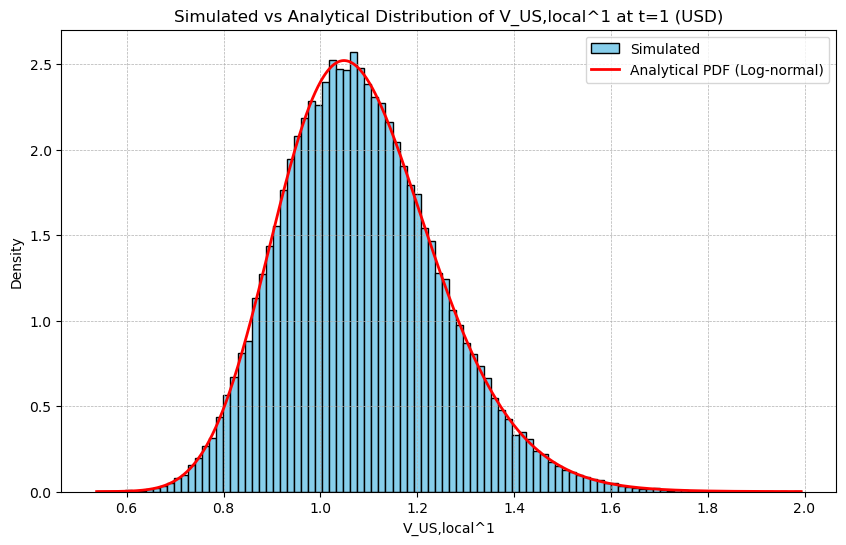

In [17]:
#Define parameters:
time_horizon=52
log_v0_us_local=x0[1]
log_v1_us_local=X_t[time_horizon,1,:]
v1_us_local=np.exp(log_v1_us_local)


#Summary statistics:
mean_V1_us_local=np.mean(v1_us_local)
std_V1_us_local=np.std(v1_us_local)

print(mean_V1_us_local, std_V1_us_local)


#Define analytical parameters:
an_mean_delta_log_v=mu[1]
an_std_delta_log_v=np.sqrt(cov_matrix[1,1])

#Calculate log values:
an_mean_log_v1_us_local=log_v0_us_local+time_horizon*an_mean_delta_log_v
an_std_log_v1_us_local=np.sqrt(time_horizon)*an_std_delta_log_v
an_var_log_v1_us_local=an_std_log_v1_us_local**2

#Real-scale values:
an_mean_v1_us_local=np.exp(an_mean_log_v1_us_local+(an_var_log_v1_us_local)/2)
an_var_v1_us_local=(np.exp(an_var_log_v1_us_local) - 1) * np.exp(2 * an_mean_log_v1_us_local + an_var_log_v1_us_local)
an_std_v1_us_local=np.sqrt(an_var_v1_us_local)


"""#Plot simulated and analytical distributions:
x=np.linspace(np.min(v1_us_local), np.max(v1_us_local), 1000)
an_pdf=lognorm.pdf(x, s=an_std_log_v1_us_local, scale=np.exp(an_mean_log_v1_us_local))
plt.figure(figsize=(10, 6))"""

"""#Plot simulated and analytical distributions:
x=np.linspace(np.min(v1_us_local), np.max(v1_us_local), 1000)
an_pdf=lognorm.pdf(x, s=an_std_log_v1_us_local, scale=an_mean_v1_us_local)
plt.figure(figsize=(10, 6))"""

#Plot simulated and analytical distributions:
x=np.linspace(np.min(v1_us_local), np.max(v1_us_local), 1000)
an_pdf=lognorm.pdf(x, s=an_std_log_v1_us_local, scale=np.exp(an_mean_log_v1_us_local))
plt.figure(figsize=(10, 6))

#Simulated histogram:
plt.hist(v1_us_local, bins=100, color='skyblue', edgecolor='black', density=True, label='Simulated')

#Analytical PDF:
plt.plot(x, an_pdf, "r-", lw=2, label='Analytical PDF (Log-normal)')
plt.xlabel('V_US,local^1')
plt.ylabel('Density')
plt.title('Simulated vs Analytical Distribution of V_US,local^1 at t=1 (USD)')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

## Question 3
Explain how to calculate the value of a EUR or USD zero coupon bond based on the vector of yields at a given point in time. What is the distribution of an initial 5 year zero coupon at the horizon? Simulate the evolution of the initial 5 year zero coupon bond. Compare the simulated data with the true analytical distribution.


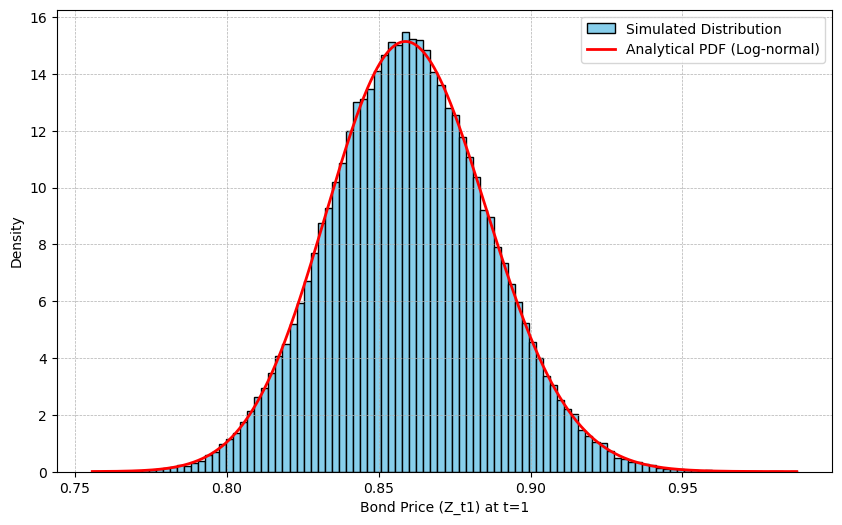

In [18]:
mu=mean_vector
time_horizon=52

#Define yield parameters for interpolation:
y0_us_3=x0[11]
y0_us_5=x0[12]
var_delta_y0_us_3=cov_matrix[11,11]
var_delta_y0_us_5=cov_matrix[12,12]

#4-year yield interpolation at t=0:
y0_us_4=y0_us_3+(4-3)/(5-3)*(y0_us_5-y0_us_3)
var_delta_y0_us_4=var_delta_y0_us_3+((4-3)/(5-3)*(var_delta_y0_us_5-var_delta_y0_us_3))
std_delta_y0_us_4=np.sqrt(var_delta_y0_us_4)

#4-year yield interpolation at t=1:
y1_us_3=x0[11]+mu[11]*time_horizon
y1_us_5=x0[12]+mu[12]*time_horizon
var_delta_y1_us_3=cov_matrix[11,11]*52
var_delta_y1_us_5=cov_matrix[12,12]*52

y1_us_4=y1_us_3+(4-3)/(5-3)*(y1_us_5-y1_us_3)
var_delta_y1_us_4=var_delta_y1_us_3+((4-3)/(5-3)*(var_delta_y1_us_5-var_delta_y1_us_3))
std_delta_y1_us_4=np.sqrt(var_delta_y1_us_4)

#Define simulation parameters:
np.random.seed(42)
num_simulations=100000
time_horizon=52
tau_1=4

#Simulation of weekly changes in 4-year yield:
delta_yt=np.random.normal(loc=0, scale=std_delta_y0_us_4, size=(time_horizon, num_simulations))
total_change=np.sum(delta_yt, axis=0)

#4-year yield at t=1:
y1_us_4_sim=y0_us_4+total_change

#4-year bond price at t=1 (Simulated):
z1_us_4_sim=np.exp(-y1_us_4_sim*tau_1)


#Analytical distribution parameters:
mean_log_z1_us_4=-tau_1*y1_us_4
var_log_z1_us_4=tau_1**2*52*var_delta_y0_us_4
std_log_z1_us_4=np.sqrt(var_log_z1_us_4)
#std_log_z1_us_4=tau_1*np.sqrt(52*var_delta_y0_us_4)
#var_log_z1_us_4=std_log_z1_us_4**2

#Real-scale values:
an_mean_log_z1_us_4=np.exp(mean_log_z1_us_4+(var_log_z1_us_4)/2)
an_var_z1_us_4=(np.exp(var_log_z1_us_4) - 1) * np.exp(2 * mean_log_z1_us_4 + var_log_z1_us_4)
an_std_z1_us_4=np.sqrt(an_var_z1_us_4)


#Analytical PDF for log-normal distribution:
x=np.linspace(np.min(z1_us_4_sim), np.max(z1_us_4_sim), 1000)
an_pdf=lognorm.pdf(x, s=std_log_z1_us_4, scale=np.exp(mean_log_z1_us_4))


#PLOTTING THE DISTRIBUTIONS:
plt.figure(figsize=(10, 6))

#Plot the histogram of simulated values:
plt.hist(z1_us_4_sim, bins=100, density=True, color='skyblue', edgecolor='black', label='Simulated Distribution')

#Plot the analytical PDF:
plt.plot(x, an_pdf, 'r-', lw=2, label='Analytical PDF (Log-normal)')

#Combining the plots:
plt.xlabel('Bond Price (Z_t1) at t=1')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

## Question 4
What is the joint distribution of the vector $P_1 = (F{X_1}, V_{1}^{US,local}, V_{1}^{EUR}, Z_{1}^{USD 4Y,local}, Z_{1}^{EUR 4Y})^T$? Here $Z_{1}^{USD 4Y,local}$ denotes a 4 year USD zero coupon bond such the investor initially has bought a 5 year zero coupon bond.


In [19]:
#Given parameters:
mu = mean_vector
time_steps = 52

#Calculate covariance matrix at t=1:
cov_1 = covariance_matrix * time_steps

#Define indices for P1 components in X1:
log_FX_index = 0
log_V_US_index = 1
log_V_EUR_index = 2
y_US_3_index = 11
y_US_5_index = 12
y_EUR_3_index = 5
y_EUR_5_index = 6

#Extract values for the P1 vector at t=0:
log_fx_0=x0[log_FX_index]
log_v0_us=x0[log_V_US_index]
log_v0_eu=x0[log_V_EUR_index]
y0_us_3=x0[y_US_3_index]
y0_us_5=x0[y_US_5_index]
y0_eu_3=x0[y_EUR_3_index]
y0_eu_5=x0[y_EUR_5_index]

#Interpolate 4-year yields at t=0:
y0_us_4 = y0_us_3 + (4 - 3) / (5 - 3) * (y0_us_5 - y0_us_3)
y0_eu_4 = y0_eu_3 + (4 - 3) / (5 - 3) * (y0_eu_5 - y0_eu_3)

#Calculate log bond prices at t=0:
log_z0_us_4 = -4 * y0_us_4
log_z0_eu_4 = -4 * y0_eu_4

#Define the constants vector b:
b = np.array([log_fx_0, log_v0_us, log_v0_eu, log_z0_us_4, log_z0_eu_4])

#Define the affine transformation matrix A:
A = np.array([
    [1, 0, 0,  0,  0,  0,  0],
    [0, 1, 0,  0,  0,  0,  0],
    [0, 0, 1,  0,  0,  0,  0],
    [0, 0, 0, -2, -2,  0,  0],
    [0, 0, 0,  0,  0, -2, -2],
])

#Annual drift vector:
annual_mu_with_drift = np.array([0, 0.07, 0.06, 0, 0, 0, 0])

#Calculate the mean of log(P1) using the affine transformation:
mean_log_P1 = A @ annual_mu_with_drift + b
print(mean_log_P1)

#Extract the covariance matrix:
cov_1_ext = cov_1.loc[
    ["fx_spot", "EQV US", "EQV EUR", "3Y USD", "5Y USD", "3Y EUR", "5Y EUR"],
    ["fx_spot", "EQV US", "EQV EUR", "3Y USD", "5Y USD", "3Y EUR", "5Y EUR"]
].values

#Calculate the covariance of P1 using the affine transformation:
cov_log_P1=A @ cov_1_ext @ A.T
columns = ['log_FX_1', 'log_V_USD_1', 'log_V_EUR_1', 'log_Z_4Y_USD', 'log_Z_4Y_EUR']
cov_log_p1_df = pd.DataFrame(cov_log_P1, index=columns, columns=columns)
print(cov_log_p1_df)

#Bringing mean and covariance matrix out of log-space:
var_log_p1=np.diag(cov_log_P1)
mean_real_p1=np.exp(mean_log_P1+var_log_p1/2)

exp_cov_log_p1 = np.exp(cov_log_P1)
cov_real_p1 = (exp_cov_log_p1 - 1) * (mean_real_p1[:, None] @ mean_real_p1[None, :])

#Labelling:
columns = ['FX_1', 'V_USD_1', 'V_EUR_1', 'Z_4Y_USD', 'Z_4Y_EUR']
cov_real_p1_df = pd.DataFrame(cov_real_p1, index=columns, columns=columns)
mean_real_p1_df = pd.DataFrame(mean_real_p1, index=columns)
print(f"Mean P1:\n {mean_real_p1_df}"
      f"\n\nCov Mat P1:\n {cov_real_p1_df}")


[ 0.05529279  0.07        0.06       -0.15123019 -0.07951929]
              log_FX_1  log_V_USD_1  log_V_EUR_1  log_Z_4Y_USD  log_Z_4Y_EUR
log_FX_1      0.005865     0.001998    -0.000245      0.000640      0.000081
log_V_USD_1   0.001998     0.022256     0.017473     -0.000395      0.000643
log_V_EUR_1  -0.000245     0.017473     0.024203     -0.000750      0.000358
log_Z_4Y_USD  0.000640    -0.000395    -0.000750      0.000920      0.000506
log_Z_4Y_EUR  0.000081     0.000643     0.000358      0.000506      0.000569
Mean P1:
                  0
FX_1      1.059954
V_USD_1   1.084510
V_EUR_1   1.074765
Z_4Y_USD  0.860045
Z_4Y_EUR  0.923823

Cov Mat P1:
               FX_1   V_USD_1   V_EUR_1  Z_4Y_USD  Z_4Y_EUR
FX_1      0.006608  0.002299 -0.000279  0.000583  0.000080
V_USD_1   0.002299  0.026471  0.020545 -0.000369  0.000644
V_EUR_1  -0.000279  0.020545  0.028299 -0.000693  0.000355
Z_4Y_USD  0.000583 -0.000369 -0.000693  0.000681  0.000402
Z_4Y_EUR  0.000080  0.000644  0.000355  0.0

## Question 5
What is the distribution of the vector $P_{1}^{EUR} = (\frac{1}{F{X_1}}, V_{1}^{US}, V_{1}^{EUR}, Z_{1}^{USD 4Y}, Z_{1}^{EUR 4Y})^T$ where all values are in EUR? Compare the simulated data with the true analytical distribution for $V_{1}^{US}$.


Mean log P1 EUR:
 [-0.05529279  0.01470721  0.06       -0.20652297 -0.07951929]
Cov Mat log P1 EUR:
                      log(1/FX_1)  log_V_USD_1 in EUR  log_V_EUR_1  \
log(1/FX_1)             0.005865            0.003867     0.000245   
log_V_USD_1 in EUR      0.003867            0.024125     0.017718   
log_V_EUR_1             0.000245            0.017718     0.024203   
log_Z_4Y_USD in EUR     0.005225            0.002832    -0.000505   
log_Z_4Y_EUR           -0.000081            0.000561     0.000358   

                     log_Z_4Y_USD in EUR  log_Z_4Y_EUR  
log(1/FX_1)                     0.005225     -0.000081  
log_V_USD_1 in EUR              0.002832      0.000561  
log_V_EUR_1                    -0.000505      0.000358  
log_Z_4Y_USD in EUR             0.005505      0.000425  
log_Z_4Y_EUR                    0.000425      0.000569  
Mean P1 EUR:
                         0
1/FX_1           0.948987
V_USD_1 in EUR   1.027131
V_EUR_1          1.074765
Z_4Y_USD in EUR  0.81565

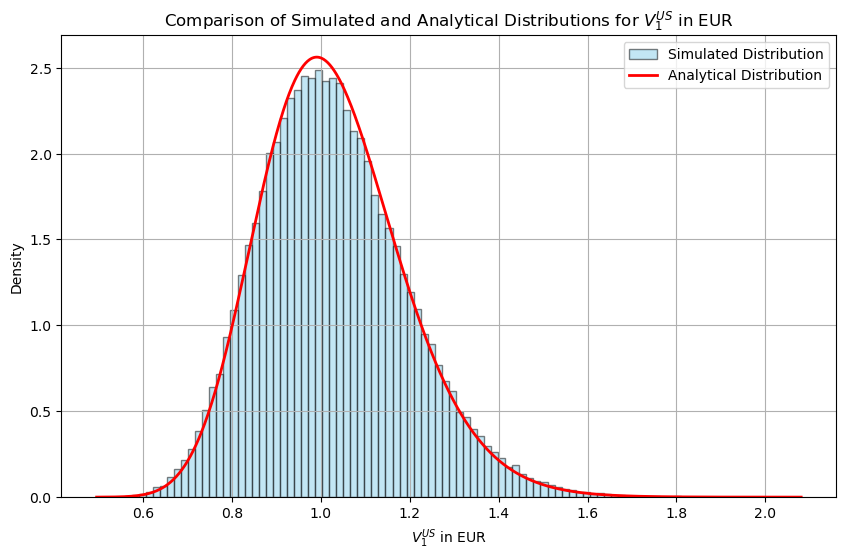

In [20]:


C = np.array([
    [-1,  0,  0,  0,  0],  # Log(1/FX) = -Log FX
    [-1,  1,  0,  0,  0],  # Log V_US - Log FX
    [ 0,  0,  1,  0,  0],  # Log V_EUR
    [-1,  0,  0,  1,  0],  # Log Z_USD (4Y) - Log FX
    [ 0,  0,  0,  0,  1],  # Log Z_EUR (4Y)
])

#Compute transformed mean vector:
mean_log_p1_eur=C@mean_log_P1
print(f"Mean log P1 EUR:\n {mean_log_p1_eur}")

#Compute transformed covariance matrix:
cov_log_p1_eur=C@cov_log_P1@C.T
columns = ['log(1/FX_1)', 'log_V_USD_1 in EUR', 'log_V_EUR_1', 'log_Z_4Y_USD in EUR', 'log_Z_4Y_EUR']
cov_log_p1_eur_df = pd.DataFrame(cov_log_p1_eur, index=columns, columns=columns)
print(f"Cov Mat log P1 EUR:\n {cov_log_p1_eur_df}")

#Bringing mean and covariance matrix out of log-space:
var_log_p1_eur=np.diag(cov_log_p1_eur)
var_log_V1_eur=cov_log_p1_eur_df.loc["log_V_USD_1 in EUR", "log_V_USD_1 in EUR"]
mean_real_p1_eur=np.exp(mean_log_p1_eur+var_log_p1_eur/2)
mean_log_V1_eur=mean_log_p1_eur[1]

exp_cov_log_p1_eur = np.exp(cov_log_p1_eur)
cov_real_p1_eur = (np.exp(cov_log_p1_eur) - 1) * np.exp(np.add.outer(mean_log_p1_eur, mean_log_p1_eur) + cov_log_p1_eur)


#Labelling:
columns = ['1/FX_1', 'V_USD_1 in EUR', 'V_EUR_1', 'Z_4Y_USD in EUR', 'Z_4Y_EUR']
cov_real_p1_eur_df = pd.DataFrame(cov_real_p1_eur, index=columns, columns=columns)
mean_real_p1_eur_df = pd.DataFrame(mean_real_p1_eur, index=columns)
print(f"Mean P1 EUR:\n {mean_real_p1_eur_df}"
      f"\n\nCov Mat P1 EUR:\n {cov_real_p1_eur_df}")

#Compare analytical distribution for V_US with the simulated distribution:
v1_us_mean=mean_real_p1_eur_df.iloc[1]
v1_us_var=cov_real_p1_eur_df.loc["V_USD_1 in EUR", "V_USD_1 in EUR"]


#Number of simulations:
num_simulations = 100000
np.random.seed(42)

#Simulate V1^US in EUR:
simulated_v1_us_eur = np.random.lognormal(
    mean=np.log(v1_us_mean) - 0.5 * v1_us_var,
    sigma=np.sqrt(v1_us_var),
    size=num_simulations
)

"""#Analytical distribution parameters:
x_values = np.linspace(min(simulated_v1_us_eur), max(simulated_v1_us_eur), 1000)
pdf_values = lognorm.pdf(x_values, s=np.sqrt(v1_us_var), scale=v1_us_mean)"""

#Analytical distribution parameters:
x_values = np.linspace(min(simulated_v1_us_eur), max(simulated_v1_us_eur), 1000)
pdf_values = lognorm.pdf(x_values, s=np.sqrt(var_log_V1_eur), scale=np.exp(mean_log_V1_eur))



#Plotting the distributions:
plt.figure(figsize=(10, 6))
plt.hist(simulated_v1_us_eur, bins=100, alpha=0.5, density=True, color='skyblue', edgecolor='black', label='Simulated Distribution')
plt.plot(x_values, pdf_values, 'r', label='Analytical Distribution', linewidth=2)
plt.title('Comparison of Simulated and Analytical Distributions for $V_{1}^{US}$ in EUR')
plt.xlabel('$V_{1}^{US}$ in EUR')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


## Question 6
The one year FX forward price is given by

$$
F_0^1 = F{X_0} e^{1\cdot(y_{0}^{USD,1} - y_{0}^{EUR,1})}
$$

which is the exchange rate (the price of one EUR in USD) that the investor can lock in at time zero.

The investor can choose a 5 x 1 holding vector **$h$** which defines the number of units in each asset / instrument. The first instrument is a FX forward that gives the investor the right and obligation to sell 1 unit of USD for the price $1/F_0^1$ in one year while the remaining assets are the ones discussed above. Note that the forward contract has a value of zero initially. The portfolio PnL of the investor is given by the product of the holding vector and the vector of PnLs

$$
PnL_1 = {\bf h^T PnL_1}
$$

where

$$
{\bf PnL_1} = \begin{pmatrix}
\frac{1}{F_0^1} - \frac{1}{F_{X_1}} \\
V_{1}^{US} - V_{0}^{US} \\
V_{1}^{EUR} - V_{0}^{EUR} \\
Z_{1}^{USD 4Y} - Z_{0}^{USD 5Y} \\
Z_{1}^{EUR 4Y} - Z_{0}^{EUR 5Y}
\end{pmatrix}
$$



How could we calculate the expectation and the covariance matrix of the PnL vector? What is the distribution of the PnL vector? Can we derive the distribution of the PnL of the portfolio? What is the expectation and variance of the portfolio PnL?




In [21]:
# Forward price calculation
fx0=np.exp(x0[0])
F0_1=fx0*np.exp(1*(x0[10]-x0[4]))

#Expected value of the PnL1 vector:
#FX Forward PnL
E_pnl_fx=(1/F0_1)-mean_real_p1_eur_df.iloc[0]

#EQV US in EUR:
E_pnl_v_us=mean_real_p1_eur_df.iloc[1]-(np.exp(x0[1])/fx0)

#EQV EUR:
E_pnl_v_eur=mean_real_p1_eur_df.iloc[2]-np.exp(x0[2])

#Price of US bond in EUR:
    #Calculating Z0:
mean_x0=x0+mean_vector
t=5
mean_y0_us_5=mean_x0[12]
var_y0_us_5=cov_matrix[12,12]

mean_z0_us_5_local=np.exp(-mean_y0_us_5*t+(t**2*var_y0_us_5)/2) #This formula is different from the one that the others use (it produces a slightly differetn result)
var_z0_us_5_local=np.exp(-2*t*mean_y0_us_5+(t**2)*var_y0_us_5)*(np.exp((t**2)*(var_y0_us_5))-1)

mean_z0_us_5=mean_z0_us_5_local/fx0

    #PnL:
E_pnl_z_us=mean_real_p1_eur_df.iloc[3]-mean_z0_us_5

#Price of EUR bond:
    #Calculating Z0:
mean_y0_eur_5=mean_x0[6]
var_y0_eur_5=cov_matrix[6,6]

mean_z0_eur_5=np.exp(-mean_y0_eur_5*t+(t**2*var_y0_eur_5)/2)
var_z0_eur_5=np.exp(-2*t*mean_y0_eur_5+(t**2)*var_y0_eur_5)*(np.exp((t**2)*(var_y0_eur_5))-1)

    #PnL:
E_pnl_z_eur=mean_real_p1_eur_df.iloc[4]-mean_z0_eur_5

#Expected value of the PnL1 vector:
E_pnl1=np.array([E_pnl_fx,E_pnl_v_us,E_pnl_v_eur,E_pnl_z_us,E_pnl_z_eur])

# Convert P1 EUR to PnL
# Transformation matrix C
C = np.array([
    [-1,  0,  0,  0,  0],  # -(1/FX)
    [ 0,  1,  0,  0,  0],  # V_US
    [ 0,  0,  1,  0,  0],  # V_EUR
    [ 0,  0,  0,  1,  0],  # Z_USD (4Y)
    [ 0,  0,  0,  0,  1],  # Z_EUR (4Y)
])

""" # Compute the transformed mean vector
mean_log_p1_eur = C @ mean_log_p1
print(mean_log_p1_eur) """

# Transform the covariance matrix
cov_pnl1 = C @ cov_real_p1_eur_df @ C.T
cov_pnl1.shape

print(E_pnl1)
print(cov_pnl1)
print(fx0)

"""h=np.array([1,1,1,1,1])
E_pnl1_p=np.dot(h,E_pnl1)
var_pnl1_p=np.dot(h.T,np.dot(cov_pnl1,h))

print(E_pnl1_p)
print(var_pnl1_p)
"""



[[-0.02077873]
 [ 0.08092331]
 [ 0.0747646 ]
 [ 0.03084563]
 [ 0.0191912 ]]
          0         1         2         3         4
0  0.005297 -0.003734 -0.000246 -0.004053  0.000071
1 -0.003734  0.025762  0.019607  0.002347  0.000527
2 -0.000246  0.019607  0.028299 -0.000436  0.000351
3 -0.004053  0.002347 -0.000436  0.003673  0.000319
4  0.000071  0.000527  0.000351  0.000319  0.000485
1.05685


'h=np.array([1,1,1,1,1])\nE_pnl1_p=np.dot(h,E_pnl1)\nvar_pnl1_p=np.dot(h.T,np.dot(cov_pnl1,h))\n\nprint(E_pnl1_p)\nprint(var_pnl1_p)\n'

## Question 7
The optimal number of FX forward contracts, $h_1$, to minimize the PnL variance for a fixed allocation to the remaining assets $h_2$ ($h = (h_1, h_2^T)^T$) is given by

$$
h_1 = \frac{-\Sigma^{PnL}_{12} h_2}{\Sigma^{PnL}_{11}}
$$

where

$$
\Sigma_{PnL} = \begin{pmatrix}
\Sigma^{PnL}_{11} & \Sigma^{PnL}_{12} \\
\Sigma^{PnL}_{21} & \Sigma^{PnL}_{22}
\end{pmatrix}
$$



Define the hedge ratio as the amount USD hedged (the number of forward contracts) relative to the amount of USD invested. Consider three different portfolios: One that invests 1 EUR in US equities, one that invests 1 EUR in 5 year USD zero coupon bond and one that invests 0.2 EUR in both US and EUR equities and 0.3 EUR in both EUR and USD zero coupon bonds. For the three portfolios plot the combinations of standard deviation and expected PnL for hedge ratios ranging from -1 to 1.5. Calculate the optimal hedge ratios for each portfolio and add their standard deviation and expected PnL to the plots. What do you observe?


0.005296974403192497
1   -0.003734
2   -0.000246
3   -0.004053
4    0.000071
Name: 0, dtype: float64
0.6670980733637724 0.72398455051729 0.7111869752789022
0.7050225988345029 0.7651430722141981 0.3758089774117539


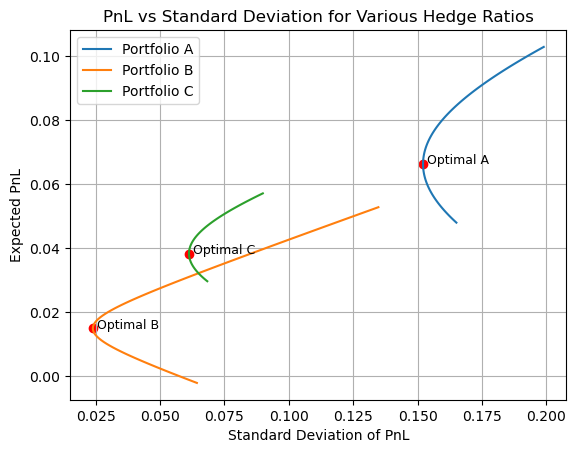

In [22]:
# Given covariance matrix components
sigma_pnl_11=cov_pnl1.iloc[0,0]
sigma_pnl_12=cov_pnl1.iloc[0,1:]

print(sigma_pnl_11)
print(sigma_pnl_12)


#CALCULATING THE HEDGE RATIO FOR EACH PORTFOLIO:
#Portfolio A:
h2_A=np.array([1,0,0,0])
optimal_h1_A=-np.dot(sigma_pnl_12,h2_A)/sigma_pnl_11
usd_exposure_A=(h2_A[0]+h2_A[2])*fx0
hr_A=optimal_h1_A/usd_exposure_A

#Portfolio B:
h2_B=np.array([0,0,1,0])
optimal_h1_B=-np.dot(sigma_pnl_12,h2_B)/sigma_pnl_11
usd_exposure_B=(h2_B[0]+h2_B[2])*fx0
hr_B=optimal_h1_B/usd_exposure_B

#Portfolio C:
h2_C=np.array([0.2, 0.2, 0.3, 0.3])
optimal_h1_C=-np.dot(sigma_pnl_12,h2_C)/sigma_pnl_11
usd_exposure_C=(h2_C[0]+h2_C[2])*fx0
hr_C=optimal_h1_C/usd_exposure_C

optimal_hr=np.array([hr_A,hr_B,hr_C])
print(hr_A,hr_B,hr_C)
print(optimal_h1_A, optimal_h1_B, optimal_h1_C)


portfolios = {
    'A': {'h2': np.array([1, 0, 0, 0]), 'hr': hr_A, 'exposure': usd_exposure_A, 'h1': optimal_h1_A},
    'B': {'h2': np.array([0, 0, 1, 0]), 'hr': hr_B, 'exposure': usd_exposure_B, 'h1': optimal_h1_B},
    'C': {'h2': np.array([0.2, 0.2, 0.3, 0.3]), 'hr': hr_C, 'exposure': usd_exposure_C, 'h1': optimal_h1_C},
}

hedge_ratios = np.linspace(-1, 1.5, 100)

# Function to compute PnL and standard deviation
def compute_metrics(h1, h2):
    h = np.concatenate(([h1], h2))
    expected_pnl = np.dot(h, E_pnl1)
    variance_pnl = np.dot(h.T, np.dot(cov_pnl1, h))
    std_dev_pnl = np.sqrt(variance_pnl)
    return expected_pnl, std_dev_pnl


# Initialize plot
fig, ax = plt.subplots()

# Iterate over portfolios and plot
for portfolio, data in portfolios.items():
    # Separate expected PnL and standard deviation
    results = [compute_metrics(data['exposure'] * x, data['h2']) for x in hedge_ratios]
    expected_pnls = [result[0] for result in results]
    std_devs = [result[1] for result in results]

    ax.plot(std_devs, expected_pnls, label=f'Portfolio {portfolio}')

    # Optimal point
    optimal_pnl, optimal_std = compute_metrics(data['h1'], data['h2'])
    ax.scatter(optimal_std, optimal_pnl, color='red')
    ax.text(optimal_std, optimal_pnl, f' Optimal {portfolio}', fontsize=9)

# Final plot settings
ax.set_xlabel('Standard Deviation of PnL')
ax.set_ylabel('Expected PnL')
ax.set_title('PnL vs Standard Deviation for Various Hedge Ratios')
ax.legend()
ax.grid(True)
plt.show()




## Question 8
For the multi-asset portfolio, describe how to find the minimum 5% CVaR hedge ratio. Plot the combinations of 5% CVaR and expected PnL for hedge ratios ranging from -1 to 1.5. What do you observe?


Optimal Hedge Ratio for Minimum 5% CVaR: 0.264
5% CVaR with Optimal Hedge Ratio: 0.088
Expected PnL with Optimal Hedge Ratio: 0.041


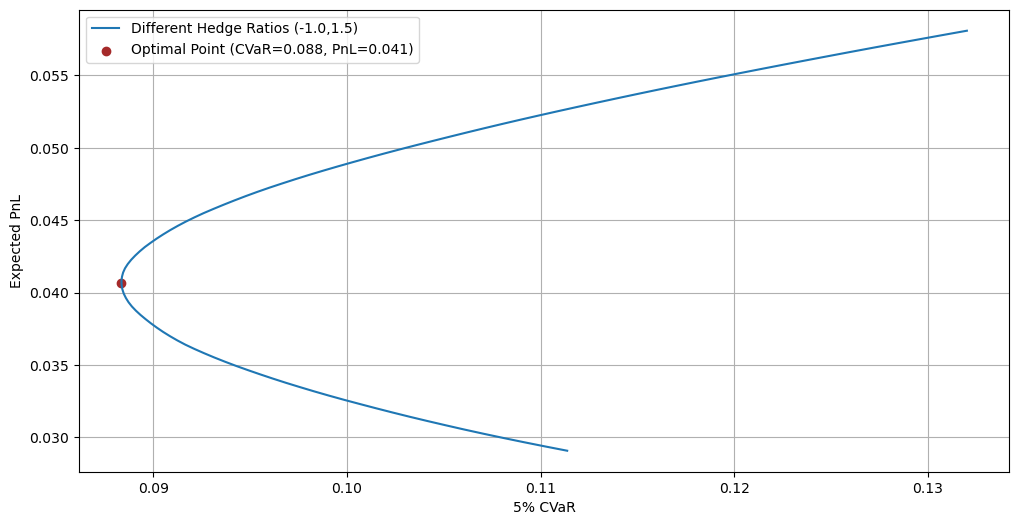

[-0.02077873  0.08092331  0.0747646   0.03084563  0.0191912 ]           0         1         2         3         4
0  0.005297 -0.003734 -0.000246 -0.004053  0.000071
1 -0.003734  0.025762  0.019607  0.002347  0.000527
2 -0.000246  0.019607  0.028299 -0.000436  0.000351
3 -0.004053  0.002347 -0.000436  0.003673  0.000319
4  0.000071  0.000527  0.000351  0.000319  0.000485 1.05685


In [23]:
E_pnl1 = E_pnl1.flatten()

def calculate_cvar(w: np.ndarray, returns: np.ndarray, beta: float = 0.95):
    # portfolio returns
    port_returns = returns @ w

    # percentile
    perc = np.percentile(port_returns, (1 - beta) * 100)

    # average in tail
    avg_tail = np.mean(port_returns[port_returns <= perc])

    return -avg_tail

#Define inputs:
num_simulations=10000
np.random.seed(42)

#Simulate portfolio returns:
sim_pnl_ret = np.random.multivariate_normal(E_pnl1, cov_pnl1, num_simulations)

#Defining the objective function for optimization (minimise 5% CVaR):
def objective(hedge_ratio):
    h1=hedge_ratio*usd_exposure_C
    h=np.concatenate((h1,h2_C))
    return calculate_cvar(h, sim_pnl_ret, beta=0.95)

#Optimizing the objective function:
result=minimize(
    fun=objective,
    x0=[0],
    bounds=[(-1, 1.5)],
    method="SLSQP"
)

# Extract the optimal hedge ratio
optimal_hedge_ratio = result.x[0]
optimal_h1 = optimal_hedge_ratio * usd_exposure_C
print(f'Optimal Hedge Ratio for Minimum 5% CVaR: {optimal_h1:.3f}')

# Combine the optimal hedge ratio h1 with h2 to create the full portfolio weights
h_optimal = np.concatenate(([optimal_h1], h2_C))

# Calculate portfolio returns using the optimal weights
portfolio_returns = sim_pnl_ret @ h_optimal

# Calculate 5% CVaR and expected PnL
sorted_returns = np.sort(portfolio_returns)
cvar_5_percent = -np.mean(sorted_returns[:int(0.05 * len(sorted_returns))])
expected_pnl = np.mean(portfolio_returns)

# Print results
print(f'5% CVaR with Optimal Hedge Ratio: {cvar_5_percent:.3f}')
print(f'Expected PnL with Optimal Hedge Ratio: {expected_pnl:.3f}')


# Plot combinations of 5% CVaR and expected PnL for hedge ratios ranging from -1 to 1.5
hedge_ratios = np.linspace(-1, 1.5, 100)
cvar_values = []
expected_pnls = []

for hedge_ratio in hedge_ratios:
    h1 = hedge_ratio * usd_exposure_C  # Convert hedge ratio to h1
    h = np.concatenate(([h1], h2_C))
    portfolio_returns = sim_pnl_ret @ h
    sorted_returns = np.sort(portfolio_returns)
    cvar = -np.mean(sorted_returns[:int(0.05 * len(sorted_returns))])
    expected_return = np.mean(portfolio_returns)
    cvar_values.append(cvar)
    expected_pnls.append(expected_return)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(cvar_values, expected_pnls, label="Different Hedge Ratios (-1.0,1.5)")
plt.scatter(cvar_5_percent, expected_pnl, color='brown', label=f"Optimal Point (CVaR={cvar_5_percent:.3f}, PnL={expected_pnl:.3f})")

plt.xlabel("5% CVaR")
plt.ylabel("Expected PnL")
plt.legend()
plt.grid()
plt.show()

print(E_pnl1, cov_pnl1, fx0)


## Question 9
For the multi-asset portfolio, describe how to perform a simulation study that examines the effect of estimation uncertainty from estimating $\Sigma$ using the sample covariance matrix while keeping $\mu$ fixed. Consider a two year sample of the market invariants. Based on simulated covariance matrices, calculate optimal hedge ratios. Evaluate the simulated optimal hedge ratios using the true distributional parameters to visualize the resulting distributions of expected PnL, standard deviation, 5% CVaR, etc.


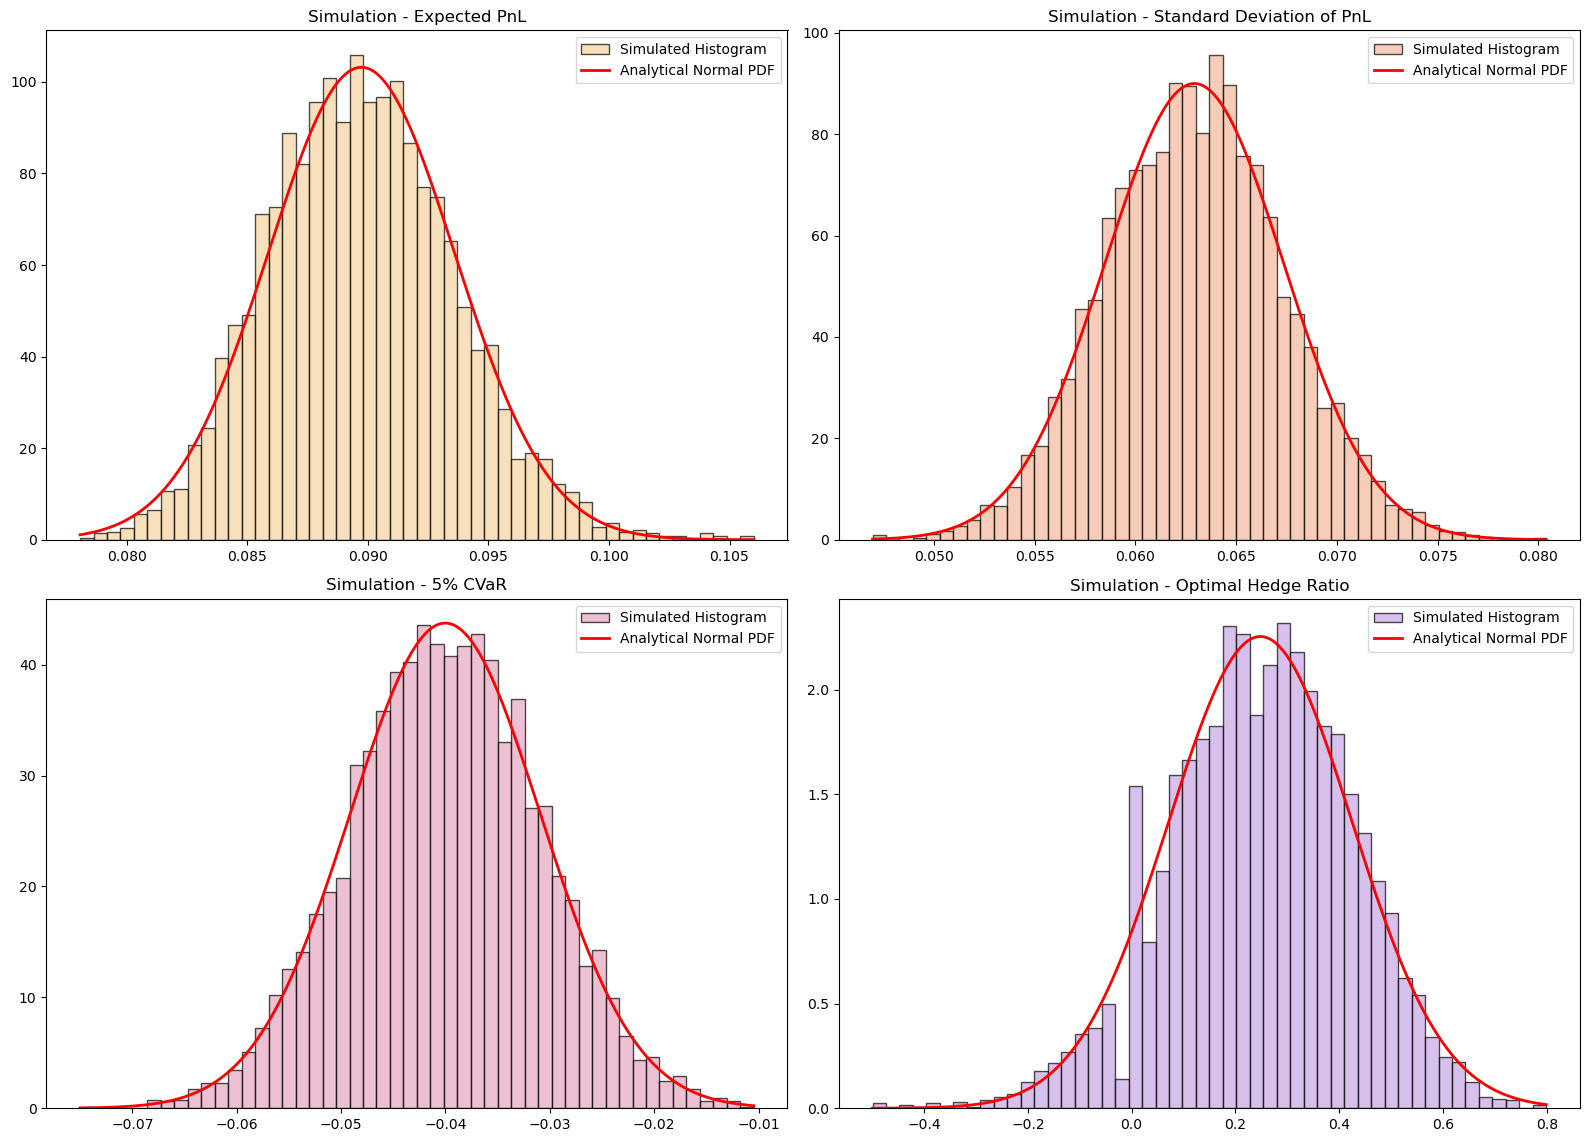

'/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Plots/Q9_Summary_Metrics.tex'

In [24]:
true_mu = E_pnl1    

# Parameters
np.random.seed(42)
num_assets = 5
n_simulations = 20000
T = 104
num_cov_samples = 5000

# True mean and covariance matrix
true_mu = (1 + np.array(true_mu))**2 - 1
true_sigma = cov_pnl1

# Function to calculate portfolio metrics
def calculate_portfolio_metrics(h, pnl_simulations):
    portfolio_returns = pnl_simulations @ h
    expected_pnl = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sorted_returns = np.sort(portfolio_returns)
    cvar_5_percent = -np.mean(sorted_returns[:int(0.05 * len(sorted_returns))])
    return expected_pnl, std_dev, cvar_5_percent

# Generate Wishart-sampled covariance matrices
wishart_cov_matrices = []
for _ in range(num_cov_samples):
    wishart_sample = stats.wishart.rvs(df=T - 1, scale=true_sigma / T)
    wishart_cov_matrices.append(wishart_sample)

# Simulation for each sample covariance matrix
portfolio_metrics = []

for sigma_sample in wishart_cov_matrices:
    pnl_simulations = np.random.multivariate_normal(true_mu, sigma_sample, n_simulations)

    def objective(hedge_ratio):
        h1 = hedge_ratio * usd_exposure_C
        h = np.concatenate((h1, h2_C))
        return calculate_portfolio_metrics(h, pnl_simulations)[2]

    result = optimize.minimize(
        fun=objective,
        x0=[0],
        bounds=[(-1, 1.5)],
        method='SLSQP'
    )
    optimal_hedge_ratio = result.x[0]
    optimal_h1 = optimal_hedge_ratio * usd_exposure_C
    h_optimal = np.concatenate(([optimal_h1], h2_C))

    expected_pnl, std_dev, cvar_5_percent = calculate_portfolio_metrics(h_optimal, pnl_simulations)
    portfolio_metrics.append({
        "Optimal Hedge Ratio": optimal_hedge_ratio,
        "5% CVaR": cvar_5_percent,
        "Expected PnL": expected_pnl,
        "Standard Deviation of PnL": std_dev,
    })

# Analytical Normal PDF on Histograms
def plot_normal_pdf(ax, data, title, color_index):
    mean = np.mean(data)
    std = np.std(data)
    x_vals = np.linspace(min(data), max(data), 1000)
    pdf_analytical = stats.norm.pdf(x_vals, loc=mean, scale=std)

    # Use pastel colors for the histogram
    ax.hist(data, bins=50, density=True, color=pastel_colors[color_index % len(pastel_colors)],
            edgecolor="black", alpha=0.7, label="Simulated Histogram")
    ax.plot(x_vals, pdf_analytical, color='red', linestyle='-', linewidth=2, label='Analytical Normal PDF')
    ax.set_title(title)
    ax.legend()

# Plot Metrics with Analytical PDFs
metrics_df = pd.DataFrame(portfolio_metrics)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Metrics to plot
metrics = [
    ("Simulation - Expected PnL", metrics_df["Expected PnL"]),
    ("Simulation - Standard Deviation of PnL", metrics_df["Standard Deviation of PnL"]),
    ("Simulation - 5% CVaR", -metrics_df["5% CVaR"]),
    ("Simulation - Optimal Hedge Ratio", metrics_df["Optimal Hedge Ratio"])
]

# Loop through metrics and axes
for i, (ax, (title, data)) in enumerate(zip(axes.flatten(), metrics)):
    plot_normal_pdf(ax, data, title, i)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Generate the LaTeX table
latex_table = metrics_df.describe().to_latex(index=True, float_format="%.4f")

# Define output file name
output_file = r"/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Plots/Q9_Summary_Metrics.tex"

# Write to file
with open(output_file, "w") as file:
    file.write(latex_table)

output_file


## Question 10
The investor is considering different portfolio optimization strategies for setting both the optimal asset weights and the optimal hedge ratio. The three possibilities are:

- Mean-Variance portfolio optimization using pre-specified hedge ratios equal to the asset specific optimal (minimum-variance) hedge ratios.
- Initial Mean-Variance portfolio optimization with a hedge ratio constrained to zero followed by choosing the hedge ratio as the minimum-variance hedge ratio.
- Full scale Mean-Variance portfolio optimization that allows the hedge ratio to be calculated directly.

Implement the three portfolio optimization strategies. A non-shorting constraint is imposed for the four assets, but not the forward contract. The investor has a budget of 1 EUR. For each strategy, the efficient frontier needs to be calculated for all possible PnL targets from the smallest to the largest. Present relevant visualizations and discuss your results.


/var/folders/wn/_zb5y8v17z9fnd0rhlddl9_00000gn/T/ipykernel_8919/4279310929.py:81: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(portfolio_std[min_var_index], portfolio_returns[min_var_index],
/var/folders/wn/_zb5y8v17z9fnd0rhlddl9_00000gn/T/ipykernel_8919/4279310929.py:83: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(portfolio_std[max_slope_index], portfolio_returns[max_slope_index],


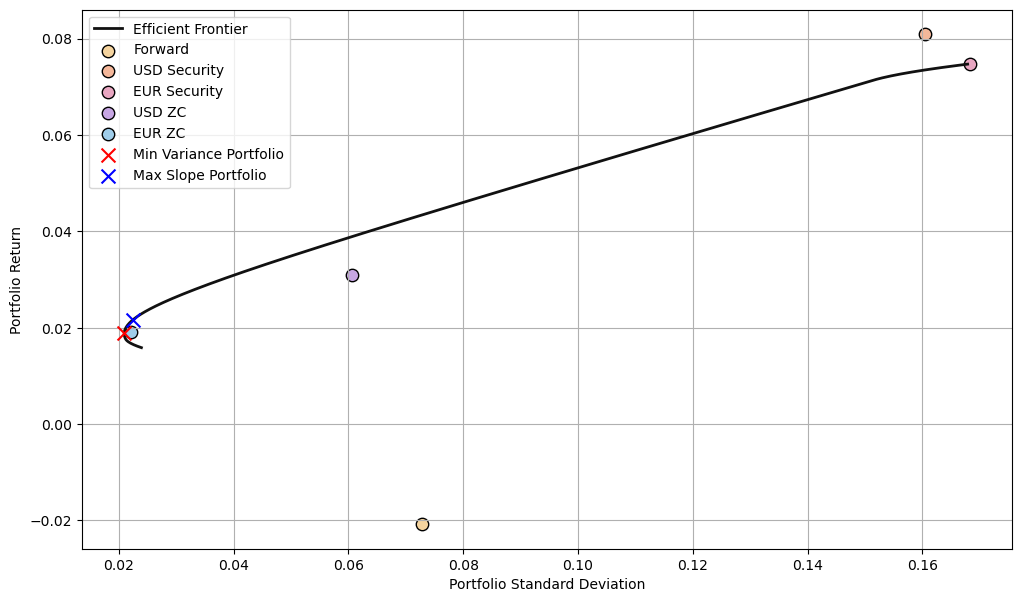

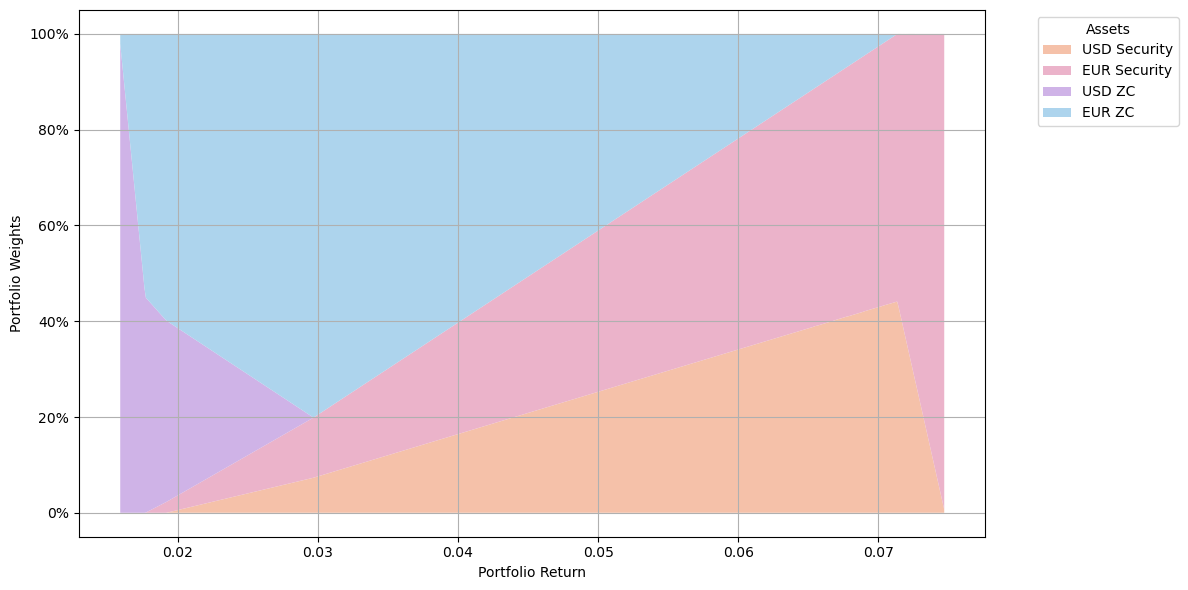

'/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Plots/max_slope_weights_1.csv'

In [36]:
# Input Data
means = E_pnl1
cov_matrix = cov_pnl1
num_assets = len(means)

# Pre-specified hedge ratios
fx_hedge_bond = hr_B  # Hedge ratio for asset 3
fx_hedge_equity = hr_A  # Hedge ratio for asset 1

# Generate return targets
mu_targets = np.linspace(min(means), max(means), 1000)

# Define CVXPY variables and constraints
weights = cp.Variable(num_assets)

constraints = [
    cp.sum(weights[1:]) == 1,  # Sum of weights excluding forward contract
    weights[1:] >= 0,  # No shorting for assets
    weights[0] == fx_hedge_equity * weights[1] + fx_hedge_bond * weights[3],  # Hedge ratio constraint
]

# Storage for results
portfolio_weights = []
portfolio_variances = []

# Solve for each target return
valid_targets = []
for pnl_target in mu_targets:
    # Add target return constraint
    constraints.append(weights @ means == pnl_target)

    # Define the optimization problem (minimize portfolio variance)
    objective = cp.Minimize(cp.quad_form(weights, cov_matrix))
    problem = cp.Problem(objective, constraints)

    try:
        # Solve the optimization problem
        problem.solve(solver=cp.SCS)
        if weights.value is not None:
            portfolio_weights.append(weights.value)
            portfolio_variances.append(weights.value @ cov_matrix @ weights.value)
            valid_targets.append(pnl_target)  # Store only valid targets
    except Exception as e:
        print(f"Optimization failed for pnl_target={pnl_target}: {e}")

    # Remove target return constraint for next iteration
    constraints.pop()

# Convert results to arrays for further analysis
portfolio_weights = np.array(portfolio_weights)
portfolio_variances = np.array(portfolio_variances)
portfolio_std = np.sqrt(portfolio_variances)
portfolio_returns = portfolio_weights @ means
valid_targets = np.array(valid_targets)

# Identify key portfolios
min_var_index = np.argmin(portfolio_variances)
max_slope_index = np.argmax(portfolio_returns / portfolio_std)

asset_labels = ["Forward", "USD Security", "EUR Security", "USD ZC", "EUR ZC"]
colors = {
    "Forward": "#F4D39E",         # Slightly darker pastel yellow
    "USD Security": "#F4B79A",    # Slightly darker pastel peach/orange
    "EUR Security": "#E8A6C1",    # Slightly darker pastel pink
    "USD ZC": "#C7A6E3",          # Slightly darker pastel purple
    "EUR ZC": "#9FCDEA"           # Slightly darker pastel blue
}
variances_assets = np.diag(cov_matrix)  # Variances of individual assets

# Efficient Frontier Plot
plt.figure(figsize=(12, 7))
plt.plot(portfolio_std, portfolio_returns, label="Efficient Frontier", color="#111111", linewidth=2)  # Black line
plt.xlabel("Portfolio Standard Deviation")
plt.ylabel("Portfolio Return")

# Annotate individual assets
for i, label in enumerate(asset_labels):
    plt.scatter(np.sqrt(variances_assets[i]), means[i], label=label, s=80, color=colors[label], edgecolor="black")  # Larger dots, black edge

# Highlight minimum variance and maximum slope portfolios
plt.scatter(portfolio_std[min_var_index], portfolio_returns[min_var_index],
            color='red', marker='x', s=100, label='Min Variance Portfolio', edgecolors='black', zorder=6)
plt.scatter(portfolio_std[max_slope_index], portfolio_returns[max_slope_index],
            color='blue', marker='x', s=100, label='Max Slope Portfolio', edgecolors='black', zorder=6)

# Add legend and grid
plt.legend()
plt.grid()
plt.show()

# Create a DataFrame for weights
weights_df = pd.DataFrame(portfolio_weights, columns=asset_labels)

# Exclude "Forward" for the weight distribution visualization
weights_df_no_forward = weights_df.drop(columns=["Forward"], errors='ignore')

# Weight Distribution Across PnL Targets
fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(
    portfolio_returns,  # Use portfolio_returns (Efficient Frontier y-axis) for the x-axis
    weights_df_no_forward.T,
    labels=weights_df_no_forward.columns,
    colors=[colors[col] for col in weights_df_no_forward.columns],
    alpha=0.85
)
# Remove the PercentFormatter for x-axis
# ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=portfolio_returns.max() * 100, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_xlabel("Portfolio Return")
ax.set_ylabel("Portfolio Weights")
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Assets")
plt.tight_layout()
plt.grid()
plt.show()

max_slope_weights_1 = portfolio_weights[max_slope_index]

max_slope_weights_df = pd.DataFrame(max_slope_weights_1, index=asset_labels, columns=["Max Slope Weights"])
output_path = r"/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Plots/max_slope_weights_1.csv"
max_slope_weights_df.to_csv(output_path, header=["Max Slope Weights"])

output_path


In [26]:
means_no_forward = true_mu[1:]


print(true_mu)
print(means_no_forward)
cov_matrix_no_forward = cov_pnl1.iloc[1:, 1:]
print(cov_pnl1)
print(cov_matrix_no_forward)

[-0.04112571  0.16839521  0.15511894  0.06264272  0.0387507 ]
[0.16839521 0.15511894 0.06264272 0.0387507 ]
          0         1         2         3         4
0  0.005297 -0.003734 -0.000246 -0.004053  0.000071
1 -0.003734  0.025762  0.019607  0.002347  0.000527
2 -0.000246  0.019607  0.028299 -0.000436  0.000351
3 -0.004053  0.002347 -0.000436  0.003673  0.000319
4  0.000071  0.000527  0.000351  0.000319  0.000485
          1         2         3         4
1  0.025762  0.019607  0.002347  0.000527
2  0.019607  0.028299 -0.000436  0.000351
3  0.002347 -0.000436  0.003673  0.000319
4  0.000527  0.000351  0.000319  0.000485


/var/folders/wn/_zb5y8v17z9fnd0rhlddl9_00000gn/T/ipykernel_8919/2209931294.py:89: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(max_sharpe_std, max_sharpe_return, color="blue", marker="x",label="Max Slope Portfolio", s=100, edgecolor="black")
/var/folders/wn/_zb5y8v17z9fnd0rhlddl9_00000gn/T/ipykernel_8919/2209931294.py:90: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(min_variance_std, min_variance_return, color="red", marker="x", label="Min Variance Portfolio", s=100, edgecolor="black")


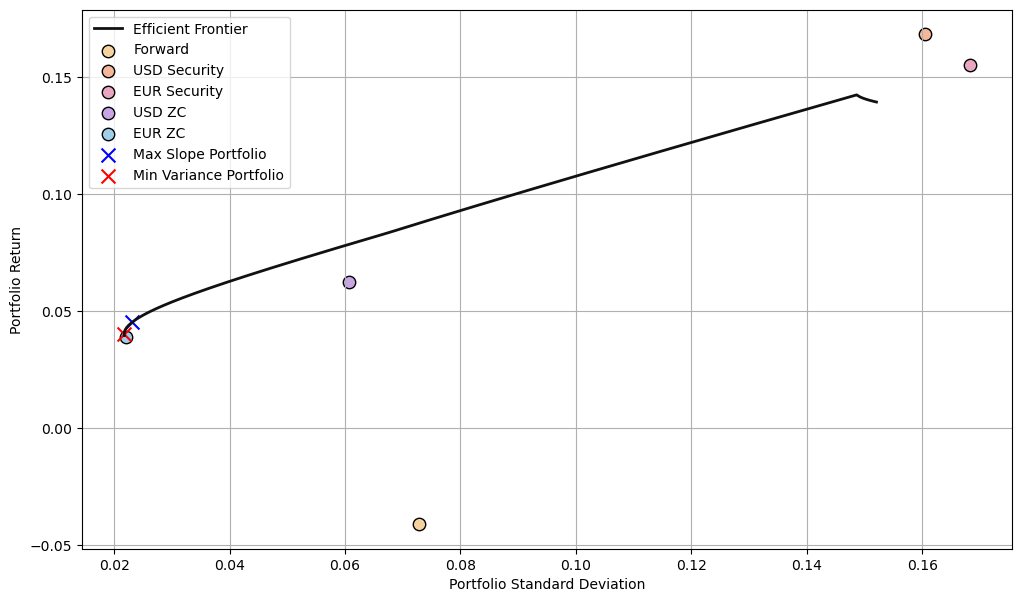

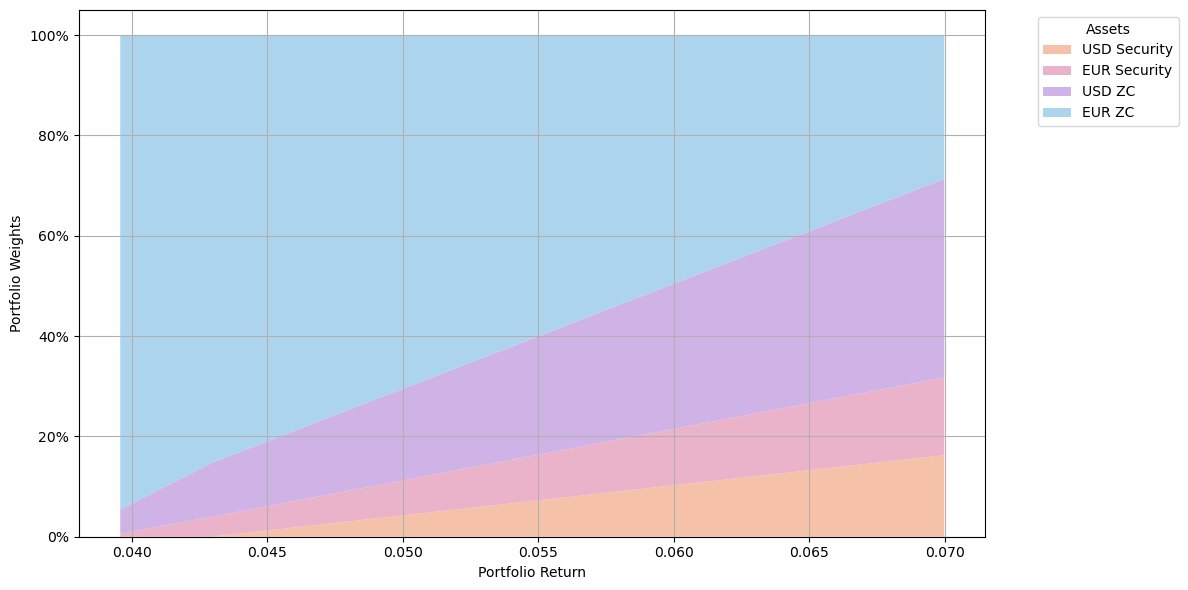

'/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Plots/max_slope_weights_2.csv'

In [27]:


num_assets_no_forward = len(means_no_forward)

# Define CVXPY variables and constraints
weights_no_forward = cp.Variable(num_assets_no_forward)
constraints = [
    cp.sum(weights_no_forward) == 1,  # Sum of weights equals 1
    weights_no_forward >= 0  # No shorting
]

# Generate return targets
mu_targets_no_forward = np.linspace(min(means_no_forward), max(means_no_forward), 1000)

# Storage for results
optimal_weights_no_forward = []
valid_targets_no_forward = []

# Solve for each target return
for pnl_target in mu_targets_no_forward:
    # Add target return constraint
    constraints.append(weights_no_forward @ means_no_forward >= pnl_target)

    # Define the optimization problem (minimize portfolio variance)
    objective = cp.Minimize(cp.quad_form(weights_no_forward, cov_matrix_no_forward))
    problem = cp.Problem(objective, constraints)

    try:
        # Solve the optimization problem
        problem.solve()
        if weights_no_forward.value is not None:
            optimal_weights_no_forward.append(weights_no_forward.value)
            valid_targets_no_forward.append(pnl_target)
    except Exception as e:
        print(f"Optimization failed for PnL target {pnl_target}: {e}")

    # Remove target return constraint for next iteration
    constraints.pop()

# Convert results to arrays for further analysis
optimal_weights_no_forward = np.array(optimal_weights_no_forward)
valid_targets_no_forward = np.array(valid_targets_no_forward)

# Integrate forward contract into portfolio
means = true_mu
cov_matrix = np.array(cov_pnl1)
block_11 = cov_matrix[:1, :1]
block_12 = cov_matrix[:1, 1:]
block_22 = cov_matrix[1:, 1:]

# Compute forward contract weights
h1_values = [-np.dot(block_12, h2_vector) / block_11 for h2_vector in optimal_weights_no_forward]
h1_values = np.array([h1.item() for h1 in h1_values])
combined_weights = np.hstack((h1_values.reshape(-1, 1), optimal_weights_no_forward))

# Analyze portfolio returns and variances
portfolio_returns = combined_weights @ means
portfolio_variances = np.array([w @ cov_matrix @ w for w in combined_weights])
portfolio_std = np.sqrt(portfolio_variances)


# Calculate Sharpe Ratios
sharpe_ratios = (portfolio_returns) / portfolio_std

# Find the maximum Sharpe Ratio and corresponding portfolio
max_sharpe_index = np.argmax(sharpe_ratios)
max_sharpe_return = portfolio_returns[max_sharpe_index]
max_sharpe_std = portfolio_std[max_sharpe_index]

min_variance_index = np.argmin(portfolio_variances)
min_variance_return = portfolio_returns[min_variance_index]
min_variance_std = portfolio_std[min_variance_index]


# Calculate individual asset variances
variances_assets = np.diag(cov_matrix)

# Define asset labels and colors
asset_labels = ["Forward", "USD Security", "EUR Security", "USD ZC", "EUR ZC"]


# Plot the Efficient Frontier
plt.figure(figsize=(12, 7))
plt.plot(portfolio_std, portfolio_returns, label="Efficient Frontier", color="#111111", linewidth=2)

# Annotate individual assets
for i, label in enumerate(asset_labels):
    plt.scatter(np.sqrt(variances_assets[i]), means[i], label=label, s=80, color=colors[label], edgecolor="black")

# Highlight the portfolio with the maximum Sharpe Ratio
plt.scatter(max_sharpe_std, max_sharpe_return, color="blue", marker="x",label="Max Slope Portfolio", s=100, edgecolor="black")
plt.scatter(min_variance_std, min_variance_return, color="red", marker="x", label="Min Variance Portfolio", s=100, edgecolor="black")

# Labels and grid
plt.xlabel("Portfolio Standard Deviation")
plt.ylabel("Portfolio Return")
plt.legend()
plt.grid()
plt.show()


# Create a DataFrame for weights
weights_df = pd.DataFrame(combined_weights, columns=asset_labels)

# Filter weights for visualization
cutoff_return = 0.07
filtered_indices = [i for i, r in enumerate(portfolio_returns) if r <= cutoff_return]
filtered_returns = portfolio_returns[filtered_indices]
filtered_weights = weights_df.iloc[filtered_indices].drop(columns=["Forward"], errors="ignore")

# Weight Distribution Across Returns
fig, ax = plt.subplots(figsize=(12, 6))
ax.stackplot(
    filtered_returns,
    filtered_weights.T,
    labels=filtered_weights.columns,
    colors=[colors[col] for col in filtered_weights.columns],
    alpha=0.85
)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_xlabel("Portfolio Return")
ax.set_ylabel("Portfolio Weights")
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Assets")
plt.tight_layout()
plt.grid()
plt.show()

# Export the weights of the maximum Sharpe Ratio portfolio to a CSV file

# Retrieve the weights corresponding to the maximum Sharpe Ratio portfolio
max_sharpe_weights = combined_weights[max_sharpe_index]

# Create a DataFrame for the weights
max_sharpe_weights_df = pd.DataFrame({
    "Asset": asset_labels,
    "Max Slope Weights": max_sharpe_weights
})

# Export the DataFrame to a CSV file
output_path = r"/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Plots/max_slope_weights_2.csv"
max_sharpe_weights_df.to_csv(output_path, index=False)

output_path


In [28]:
print(true_mu, cov_pnl1)

[-0.04112571  0.16839521  0.15511894  0.06264272  0.0387507 ]           0         1         2         3         4
0  0.005297 -0.003734 -0.000246 -0.004053  0.000071
1 -0.003734  0.025762  0.019607  0.002347  0.000527
2 -0.000246  0.019607  0.028299 -0.000436  0.000351
3 -0.004053  0.002347 -0.000436  0.003673  0.000319
4  0.000071  0.000527  0.000351  0.000319  0.000485


/var/folders/wn/_zb5y8v17z9fnd0rhlddl9_00000gn/T/ipykernel_8919/1627752163.py:67: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(max_sharpe_portfolio['Risk'], max_sharpe_portfolio['Return'], color="blue", marker="x", label="Max Sharpe Ratio Portfolio", s=100, edgecolor="black")
/var/folders/wn/_zb5y8v17z9fnd0rhlddl9_00000gn/T/ipykernel_8919/1627752163.py:68: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(min_variance_portfolio['Risk'], min_variance_portfolio['Return'], color="red", marker="x", label="Minimum Variance Portfolio", s=100, edgecolor="black")


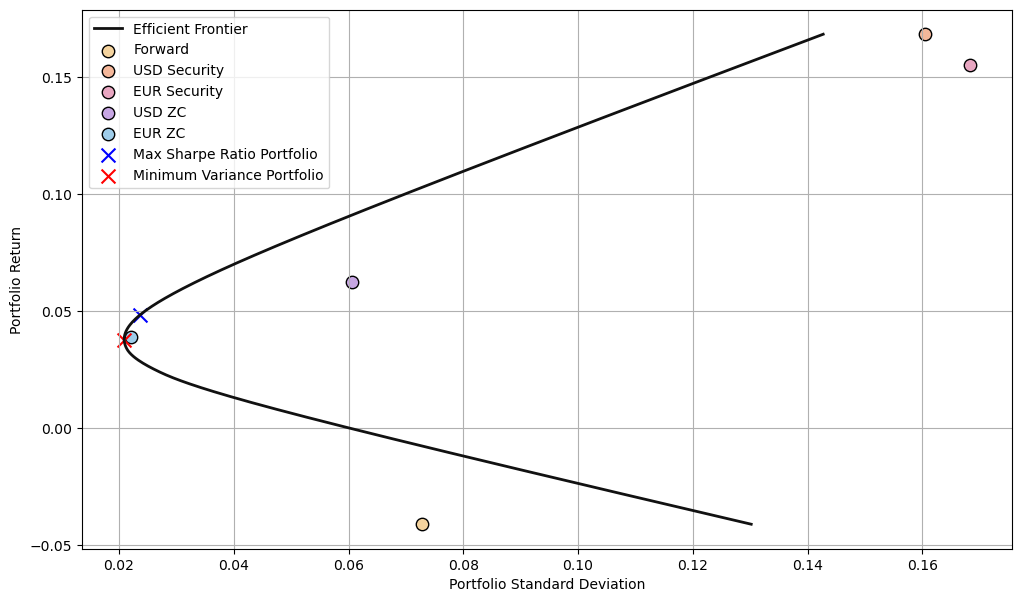

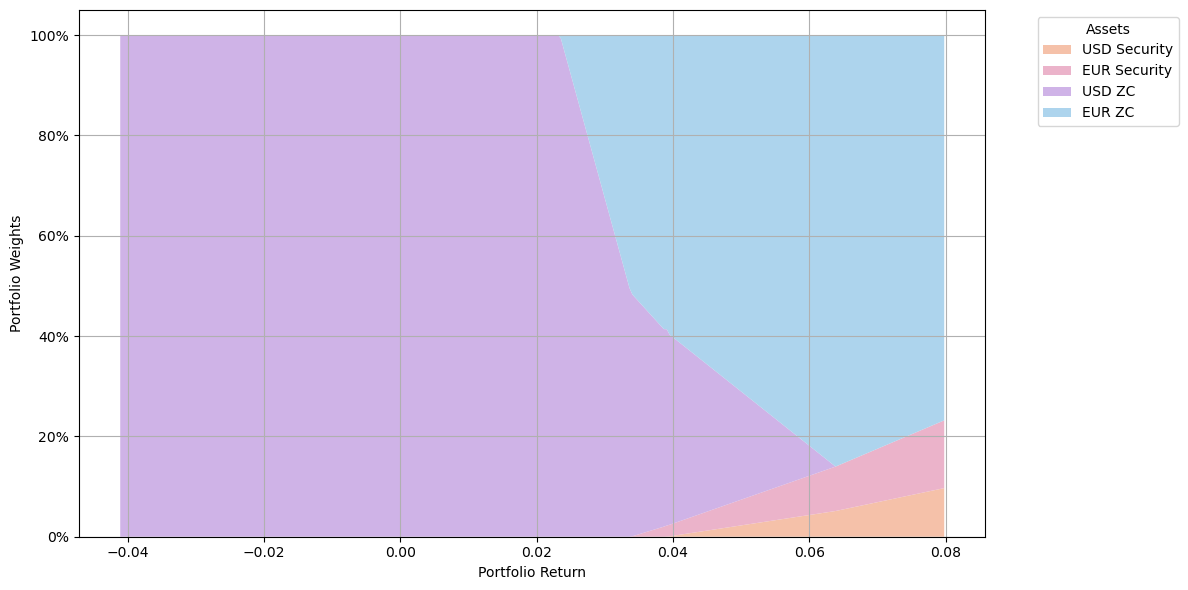

Max Sharpe Ratio portfolio weights have been saved to /Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Plots/max_slope_weights_3.csv


In [34]:
# Data input
means = true_mu
cov_matrix = cov_matrix
budget = 1  # in EUR

# Efficient frontier calculation
fine_targets = np.linspace(min(means), max(means), 500)  # Finer granularity
results_refined = []

for target in fine_targets:
    # Define cvxpy variables
    weights = cp.Variable(len(means))
    
    # Define objective function (portfolio variance)
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    
    # Define constraints
    constraints = [
        weights[1:] >= 0,  # No shorting on assets
        cp.sum(weights[1:]) == budget,  # Budget constraint
        weights @ means == target  # Target return
    ]
    
    # Solve the optimization problem
    problem = cp.Problem(cp.Minimize(portfolio_variance), constraints)
    problem.solve()
    
    if problem.status == cp.OPTIMAL:
        variance = problem.value
        results_refined.append((target, np.sqrt(variance), weights.value))

# Extract refined results for plotting
efficient_frontier_refined = pd.DataFrame(results_refined, columns=['Return', 'Risk', 'Weights'])

# Analyze the Sharpe Ratio
risk_free_rate = 0  # Assume risk-free rate is 0 for simplicity
efficient_frontier_refined['Sharpe Ratio'] = efficient_frontier_refined['Return'] / efficient_frontier_refined['Risk']

# Find maximum Sharpe Ratio portfolio
max_sharpe_idx = efficient_frontier_refined['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = efficient_frontier_refined.iloc[max_sharpe_idx]

# Find minimum variance portfolio
min_variance_idx = efficient_frontier_refined['Risk'].idxmin()
min_variance_portfolio = efficient_frontier_refined.iloc[min_variance_idx]

# Variances and Labels for Graph
variances_assets = np.diag(cov_matrix)
asset_labels = ["Forward", "USD Security", "EUR Security", "USD ZC", "EUR ZC"]
colors = {
    "Forward": "#F4D39E",         # Slightly darker pastel yellow
    "USD Security": "#F4B79A",    # Slightly darker pastel peach/orange
    "EUR Security": "#E8A6C1",    # Slightly darker pastel pink
    "USD ZC": "#C7A6E3",          # Slightly darker pastel purple
    "EUR ZC": "#9FCDEA"           # Slightly darker pastel blue
}

# Plot the Efficient Frontier
plt.figure(figsize=(12, 7))
plt.plot(efficient_frontier_refined['Risk'], efficient_frontier_refined['Return'], label="Efficient Frontier", color="#111111", linewidth=2)

# Annotate individual assets
for i, label in enumerate(asset_labels):
    plt.scatter(np.sqrt(variances_assets[i]), means[i], label=label, s=80, color=colors[label], edgecolor="black")

# Highlight the portfolio with the maximum Sharpe Ratio
plt.scatter(max_sharpe_portfolio['Risk'], max_sharpe_portfolio['Return'], color="blue", marker="x", label="Max Sharpe Ratio Portfolio", s=100, edgecolor="black")
plt.scatter(min_variance_portfolio['Risk'], min_variance_portfolio['Return'], color="red", marker="x", label="Minimum Variance Portfolio", s=100, edgecolor="black")

# Labels and grid
plt.xlabel("Portfolio Standard Deviation")
plt.ylabel("Portfolio Return")
plt.legend()
plt.grid()
plt.show()

# Weight Distribution Across Returns
weights_df = pd.DataFrame(efficient_frontier_refined['Weights'].tolist(), columns=asset_labels)
cutoff_return = 0.08
filtered_indices = efficient_frontier_refined[efficient_frontier_refined['Return'] <= cutoff_return].index
filtered_returns = efficient_frontier_refined.loc[filtered_indices, 'Return']
filtered_weights = weights_df.iloc[filtered_indices].drop(columns=["Forward"], errors="ignore")

# Stack plot of weight distribution
fig, ax = plt.subplots(figsize=(12, 6))

# Ensure color mapping aligns with the filtered weight columns
stackplot_colors = [colors[col] for col in filtered_weights.columns]

ax.stackplot(
    filtered_returns,
    filtered_weights.T,
    labels=filtered_weights.columns,
    colors=stackplot_colors,
    alpha=0.85
)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_xlabel("Portfolio Return")
ax.set_ylabel("Portfolio Weights")
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Assets")
plt.tight_layout()
plt.grid()
plt.show()

# Retrieve the weights corresponding to the maximum Sharpe Ratio portfolio
max_sharpe_weights = max_sharpe_portfolio['Weights']

# Create a DataFrame for the weights
max_sharpe_weights_df = pd.DataFrame({
    "Asset": asset_labels,
    "Max Slope Weights": max_sharpe_weights
})

# Export the DataFrame to a CSV file
output_path = r"/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Plots/max_slope_weights_3.csv"
max_sharpe_weights_df.to_csv(output_path, index=False)

# Display confirmation
print(f"Max Sharpe Ratio portfolio weights have been saved to {output_path}")

## Question 11
Perform a simulation study that examines the effect of estimation uncertainty from estimating $\Sigma$ using the sample covariance matrix while keeping $\mu$ fixed for the three strategies (consider only one or two portfolios on the efficient frontier, e.g., the minimum-variance portfolio). Present and discuss relevant results.


In [37]:
# File paths
file_1 = r'/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Plots/max_slope_weights_1.csv'
file_2 = r'/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Plots/max_slope_weights_2.csv'
file_3 = r'/Users/osito/Library/CloudStorage/OneDrive-CBS-CopenhagenBusinessSchool/Masters/3. Semester/Library/PyExam/Plots/max_slope_weights_3.csv'

# Load the CSVs
df1 = pd.read_csv(file_1)
df2 = pd.read_csv(file_2)
df3 = pd.read_csv(file_3)

# Parameters
means = true_mu
cov_matrix = cov_matrix

num_assets = len(means)
num_strategies = 3
n_simulations = 20000
T = 52
num_cov_samples = 5000

# Import CSVs for weights
weights_list = [
    pd.read_csv(file_1)["Max Slope Weights"].values,
    pd.read_csv(file_2)["Max Slope Weights"].values,
    pd.read_csv(file_3)["Max Slope Weights"].values,
]

# Generate Wishart-sampled covariance matrices
wishart_cov_matrices = [
    wishart.rvs(df=T - 1, scale=cov_matrix / T, size=1) for _ in range(num_cov_samples)
]

# Updated pastel colors
pastel_colors = ["#F4D39E", "#F4B79A", "#E8A6C1", "#C7A6E3", "#9FCDEA"]

# Function to calculate strategy metrics
def calculate_strategy_metrics(weights, pnl_simulations):
    strategy_returns = pnl_simulations @ weights
    expected_pnl = np.mean(strategy_returns)
    std_dev = np.std(strategy_returns)
    sorted_returns = np.sort(strategy_returns)
    cvar_5_percent = -np.mean(sorted_returns[:int(0.05 * len(sorted_returns))])
    return expected_pnl, std_dev, cvar_5_percent

# Function to plot histogram with true value line
def plot_histogram_with_true_value(ax, data, x_label, title, color, true_value):
    ax.hist(data, bins=50, density=True, color=color, edgecolor="black", alpha=0.7, label="Simulated Histogram")
    ax.axvline(true_value, color='red', linestyle='--', linewidth=2, label='True Value')
    ax.set_xlabel(x_label)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(visible=True, linestyle='--', alpha=0.5)  # Add gridlines for clarity

# Perform simulation for each strategy and calculate metrics
true_metrics_all_strategies = []
fig_pnl, axs_pnl = plt.subplots(1, num_strategies, figsize=(18, 6), constrained_layout=True)
fig_std, axs_std = plt.subplots(1, num_strategies, figsize=(18, 6), constrained_layout=True)
fig_cvar, axs_cvar = plt.subplots(1, num_strategies, figsize=(18, 6), constrained_layout=True)

for strategy_index, weights in enumerate(weights_list):
    strategy_metrics = []
    for sigma_sample in wishart_cov_matrices:
        # Simulate yearly PnL returns
        pnl_simulations = np.random.multivariate_normal(means, sigma_sample, n_simulations)
        
        # Calculate strategy metrics
        expected_pnl, std_dev, cvar_5_percent = calculate_strategy_metrics(weights, pnl_simulations)
        
        # Store metrics
        strategy_metrics.append({
            "Strategy": f"Strategy {strategy_index + 1}",
            "Expected PnL": expected_pnl,
            "Standard Deviation": std_dev,
            "5% CVaR": cvar_5_percent
        })

    # Create individual subplots
    metrics_df = pd.DataFrame(strategy_metrics)
    
    # Expected PnL
    plot_histogram_with_true_value(
        axs_pnl[strategy_index],
        metrics_df["Expected PnL"],
        "Expected PnL",
        f"Strategy {strategy_index + 1}",
        pastel_colors[strategy_index],
        true_value=means @ weights
    )
    
    # Standard Deviation
    plot_histogram_with_true_value(
        axs_std[strategy_index],
        metrics_df["Standard Deviation"],
        "Standard Deviation",
        f"Strategy {strategy_index + 1}",
        pastel_colors[strategy_index],
        true_value=np.sqrt(weights.T @ cov_matrix @ weights)
    )
    
    # 5% CVaR
    plot_histogram_with_true_value(
        axs_cvar[strategy_index],
        metrics_df["5% CVaR"],
        "5% CVaR",
        f"Strategy {strategy_index + 1}",
        pastel_colors[strategy_index],
        true_value=cvar_5_percent
    )


    true_metrics_all_strategies.extend(strategy_metrics)

# Save grouped figures
fig_pnl.suptitle("Expected PnL for All Strategies", fontsize=16, fontweight='bold')
fig_pnl.savefig("grouped_expected_pnl.png")
plt.close(fig_pnl)

fig_std.suptitle("Standard Deviation for All Strategies", fontsize=16, fontweight='bold')
fig_std.savefig("grouped_std_dev.png")
plt.close(fig_std)

fig_cvar.suptitle("5% CVaR for All Strategies", fontsize=16, fontweight='bold')
fig_cvar.savefig("grouped_cvar_5_percent.png")
plt.close(fig_cvar)

# Combine all strategy metrics into a DataFrame
true_combined_metrics_df = pd.DataFrame(true_metrics_all_strategies)

# Display summary statistics
summary_stats = true_combined_metrics_df.groupby("Strategy").describe()

